In [1]:
import pandas as pd
import numpy as np
from numpy.polynomial import Polynomial as P
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
#import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import re
#from visualization.plotters import gp_plot

In [2]:
#sb.color_palette("crest", as_cmap=True)

In [3]:
df = pd.read_csv('../data/mergedData.csv')
df.set_index('Timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

In [4]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nRow, nCol = df.shape
    colNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{colNames[i]}')
    plt.show()

In [5]:
df.index[-1]

Timestamp('2019-07-05 09:40:00')

In [6]:
distanceFromCage = np.array([25, 25, 25, 25, 4, 4, 4, 4, 5, 5, 2, 2, 4, 4, 5, 5, 2, 2, 4, 4, 4, 4])
direction = np.array(['C', 'C','C','C','E','N','W','S','W','W','W','W','W','W','N','N','N','N','S','S','N','W'])
#depth = np.array([int(re.search('m\d+', col).group()[1:]) for col in df.columns])

# Current plots

## Heatmaps

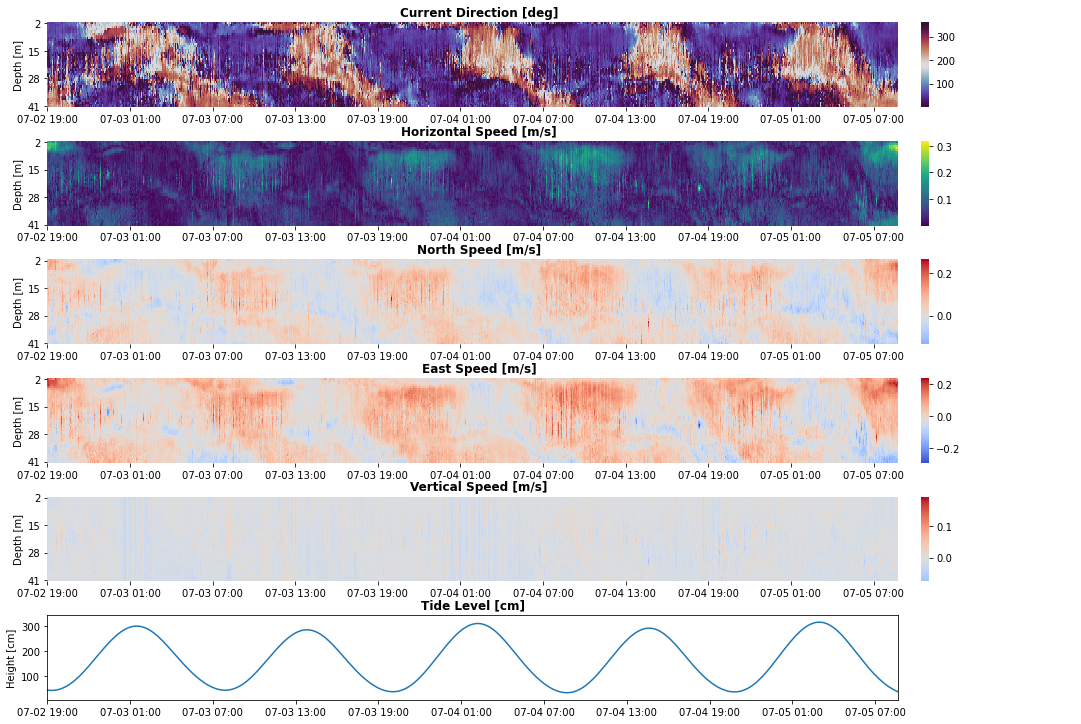

In [7]:
# TODO: Fix axis labels and ticks

timeRange = np.arange(
        '2019-07-02T19:00:00.0000000',
        '2019-07-05T09:40:00.0000000',
        np.timedelta64(360, 'm'),
        dtype='datetime64'
    )

gs = gridspec.GridSpec(nrows=6, ncols=70)

fig, ax = plt.subplots(6,1,figsize=(15,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

ax[0].set_title('Current Direction [deg]', fontweight='bold')
ax[1].set_title('Horizontal Speed [m/s]', fontweight='bold')
ax[2].set_title('North Speed [m/s]', fontweight='bold')
ax[3].set_title('East Speed [m/s]', fontweight='bold')
ax[4].set_title('Vertical Speed [m/s]', fontweight='bold')

cutFrame = df[pd.Timestamp('2019-07-02 19:00:00'):]
cutFrame.index = cutFrame.index.strftime('%m-%d %H:%M')

currentDir = cutFrame.loc[:,'CurrentDirection2m':'CurrentDirection41m'].transpose()
currentDir.index = np.arange(2,42)
currentHori = cutFrame.loc[:,'CurrentHorizontal2m':'CurrentHorizontal41m'].transpose()
currentHori.index = np.arange(2,42)
currentVert = cutFrame.loc[:,'CurrentVertical2m':'CurrentVertical41m'].transpose()
currentVert.index = np.arange(2,42)
currentNorth = cutFrame.loc[:,'CurrentNorth2m':'CurrentNorth41m'].transpose()
currentNorth.index = np.arange(2,42)
currentEast = cutFrame.loc[:,'CurrentEast2m':'CurrentEast41m'].transpose()
currentEast.index = np.arange(2,42)
tideLvl = cutFrame.loc[:,'TideLevel'].dropna().transpose()

yLabels = [2, 15, 28, 41]

p1 = sns.heatmap(currentDir, xticklabels=360, yticklabels = 13, cmap='twilight_shifted', ax=ax[0], cbar_kws=dict(pad=0.01, aspect=10))
p2 = sns.heatmap(currentHori, xticklabels=360, yticklabels = 13, cmap='viridis', ax=ax[1], cbar_kws=dict(pad=0.01, aspect=10))
p3 = sns.heatmap(currentNorth, xticklabels=360, yticklabels = 13, cmap='coolwarm', center = 0.0, ax=ax[2], cbar_kws=dict(pad=0.01, aspect=10))
p4 = sns.heatmap(currentEast, xticklabels=360, yticklabels = 13, cmap='coolwarm', ax=ax[3], cbar_kws=dict(pad=0.01, aspect=10))
p5 = sns.heatmap(currentVert, xticklabels=360, yticklabels = 13, cmap='coolwarm', ax=ax[4], center = 0.00, cbar_kws=dict(pad=0.01, aspect=10))
p1.set_yticklabels(p1.get_yticklabels(), rotation=0)
p2.set_yticklabels(p2.get_yticklabels(), rotation=0)
p3.set_yticklabels(p3.get_yticklabels(), rotation=0)
p4.set_yticklabels(p4.get_yticklabels(), rotation=0)
p5.set_yticklabels(p5.get_yticklabels(), rotation=0)
# TODO fix tide plot
locs, labels = plt.xticks()
ax5 = fig.add_subplot(gs[5,:58])
ax5.set_title('Tide Level [cm]', fontweight='bold')
ax5.plot(tideLvl.index[:-6], tideLvl.values[:-6])
#tideLvl.plot(ax=ax5, x_compat=True)
ax[5].axis("off")
ax5.margins(0.0, 0.1)
start, end = ax5.get_xlim()
ax5.xaxis.set_ticks(np.arange(start, end, 36)) 
ax5.xaxis.label.set_visible(False)
ax5.set_ylabel('Height [cm]')

for axis in ax:
    axis.xaxis.label.set_visible(False)
    axis.set_ylabel('Depth [m]')
    #axis.set_xticklabels(df.index.astype('string')[2::360])
    #axis.yaxis.set_label('Depth')

plt.savefig('currents')

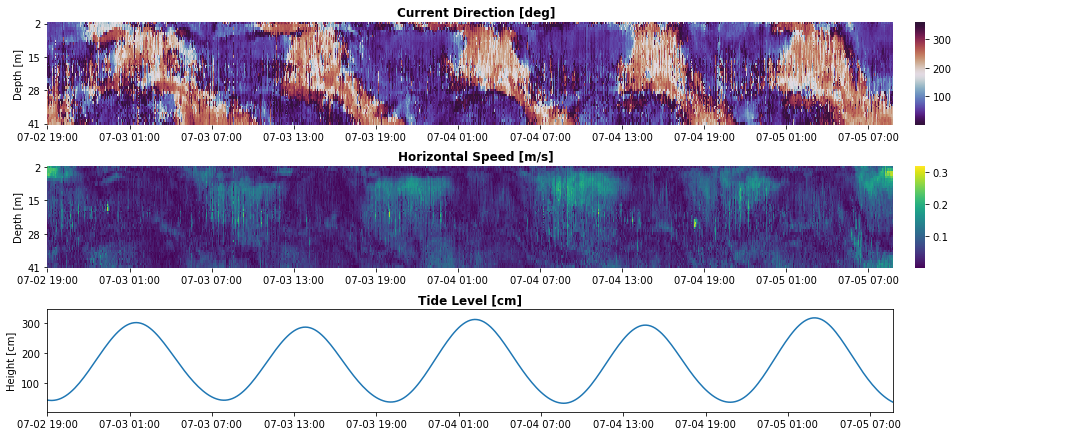

In [8]:
gs = gridspec.GridSpec(nrows=3, ncols=70)

fig, ax = plt.subplots(3,1,figsize=(15,6))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

ax[0].set_title('Current Direction [deg]', fontweight='bold')
ax[1].set_title('Horizontal Speed [m/s]', fontweight='bold')
#ax[2].set_title('North Speed [m/s]', fontweight='bold')
#ax[3].set_title('East Speed [m/s]', fontweight='bold')
#ax[4].set_title('Vertical Speed [m/s]', fontweight='bold')

cutFrame = df[pd.Timestamp('2019-07-02 19:00:00'):]
cutFrame.index = cutFrame.index.strftime('%m-%d %H:%M')

yLabels = [2, 15, 28, 41]

p1 = sns.heatmap(currentDir, xticklabels=360, yticklabels = 13, cmap='twilight_shifted', ax=ax[0], cbar_kws=dict(pad=0.01, aspect=10))
p2 = sns.heatmap(currentHori, xticklabels=360, yticklabels = 13, cmap='viridis', ax=ax[1], cbar_kws=dict(pad=0.01, aspect=10))

p1.set_yticklabels(p1.get_yticklabels(), rotation=0)
p2.set_yticklabels(p2.get_yticklabels(), rotation=0)
#p3.set_yticklabels(p3.get_yticklabels(), rotation=0)
#p4.set_yticklabels(p4.get_yticklabels(), rotation=0)
#p5.set_yticklabels(p5.get_yticklabels(), rotation=0)
# TODO fix tide plot
locs, labels = plt.xticks()
ax5 = fig.add_subplot(gs[2,:58])
ax5.set_title('Tide Level [cm]', fontweight='bold')
ax5.plot(tideLvl.index[:-6], tideLvl.values[:-6])
#tideLvl.plot(ax=ax5, x_compat=True)
ax[2].axis("off")
ax5.margins(0.0, 0.1)
start, end = ax5.get_xlim()
ax5.xaxis.set_ticks(np.arange(start, end, 36)) 
ax5.xaxis.label.set_visible(False)
ax5.set_ylabel('Height [cm]')

for axis in ax:
    axis.xaxis.label.set_visible(False)
    axis.set_ylabel('Depth [m]')
    #axis.set_xticklabels(df.index.astype('string')[2::360])
    #axis.yaxis.set_label('Depth')

plt.savefig('horiDirCurrents')

C:\Users\Lars Martin\.conda\envs\oxygenModel\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Lars Martin\.conda\envs\oxygenModel\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Lars Martin\.conda\envs\oxygenModel\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be 

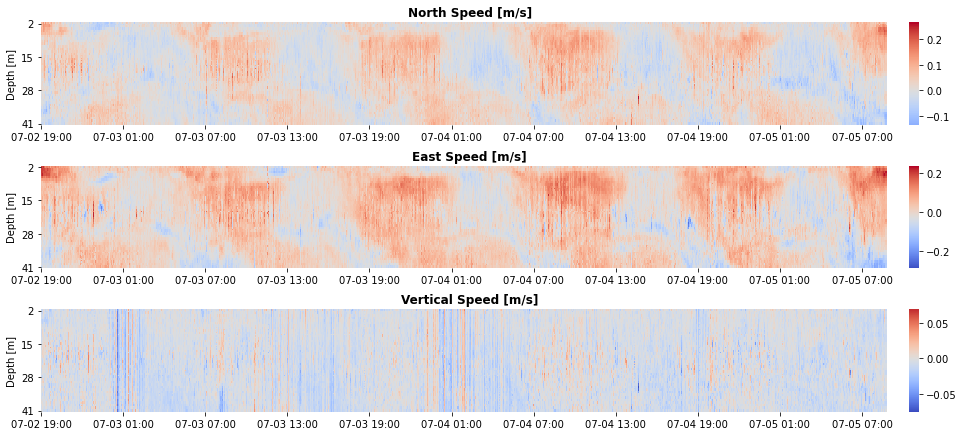

In [9]:
gs = gridspec.GridSpec(nrows=3, ncols=70)

fig, ax = plt.subplots(3,1,figsize=(15,6))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

currentVert = cutFrame.loc[:,'CurrentVertical2m':'CurrentVertical41m']
for col in currentVert.columns:
    median = currentVert[col].median()
    currentVert[col] = currentVert[col].mask(currentVert[col] > 0.07, median)
currentVert = currentVert.T
currentVert.index = np.arange(2,42)

#ax[0].set_title('Current Direction [deg]', fontweight='bold')
#ax[1].set_title('Horizontal Speed [m/s]', fontweight='bold')
ax[0].set_title('North Speed [m/s]', fontweight='bold')
ax[1].set_title('East Speed [m/s]', fontweight='bold')
ax[2].set_title('Vertical Speed [m/s]', fontweight='bold')

yLabels = [2, 15, 28, 41]

#p1 = sns.heatmap(currentDir, xticklabels=360, yticklabels = 13, cmap='twilight_shifted', ax=ax[0], cbar_kws=dict(pad=0.01, aspect=10))
#p2 = sns.heatmap(currentHori, xticklabels=360, yticklabels = 13, cmap='viridis', ax=ax[1], cbar_kws=dict(pad=0.01, aspect=10))
p3 = sns.heatmap(currentNorth, xticklabels=360, yticklabels = 13, cmap='coolwarm', center = 0.0, ax=ax[0], cbar_kws=dict(pad=0.01, aspect=10))
p4 = sns.heatmap(currentEast, xticklabels=360, yticklabels = 13, cmap='coolwarm', ax=ax[1], cbar_kws=dict(pad=0.01, aspect=10))
p5 = sns.heatmap(currentVert, xticklabels=360, yticklabels = 13, cmap='coolwarm', ax=ax[2], center = 0.00, cbar_kws=dict(pad=0.01, aspect=10))

#p1.set_yticklabels(p1.get_yticklabels(), rotation=0)
#p2.set_yticklabels(p2.get_yticklabels(), rotation=0)
p3.set_yticklabels(p3.get_yticklabels(), rotation=0)
p4.set_yticklabels(p4.get_yticklabels(), rotation=0)
p5.set_yticklabels(p5.get_yticklabels(), rotation=0)

for axis in ax:
    axis.xaxis.label.set_visible(False)
    axis.set_ylabel('Depth [m]')
    #axis.set_xticklabels(df.index.astype('string')[2::360])
    #axis.yaxis.set_label('Depth')

plt.savefig('NEVcurrents')

<AxesSubplot:xlabel='Timestamp'>

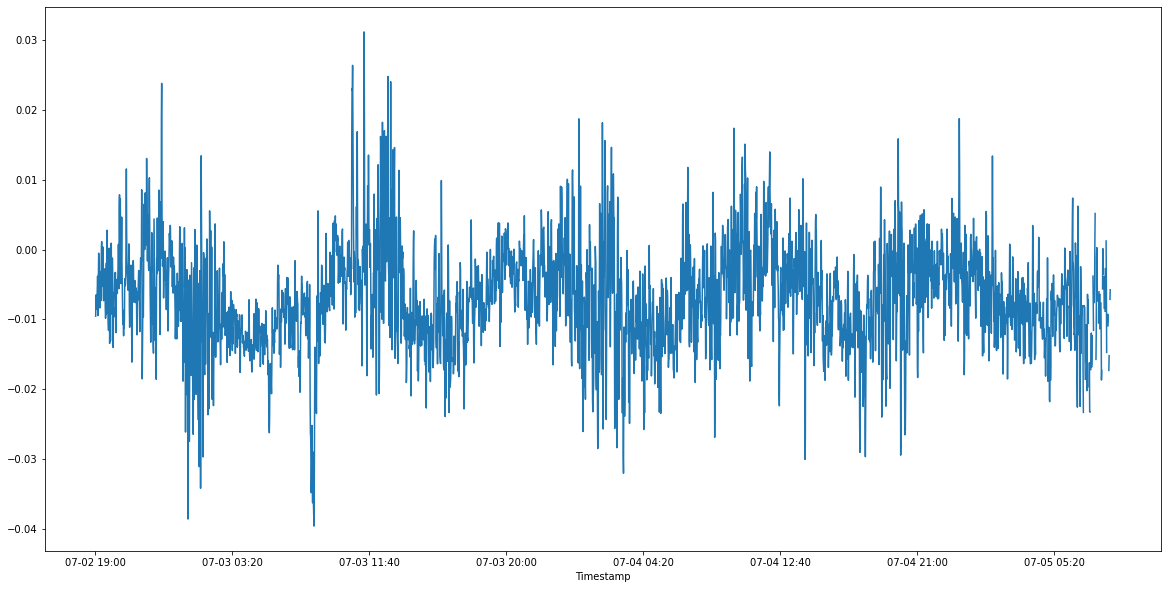

In [10]:
fig = plt.figure(figsize=(20,10))
currentVert.iloc[38].rolling(window = 2, center=True).mean().plot()

C:\Users\Lars Martin\.conda\envs\oxygenModel\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


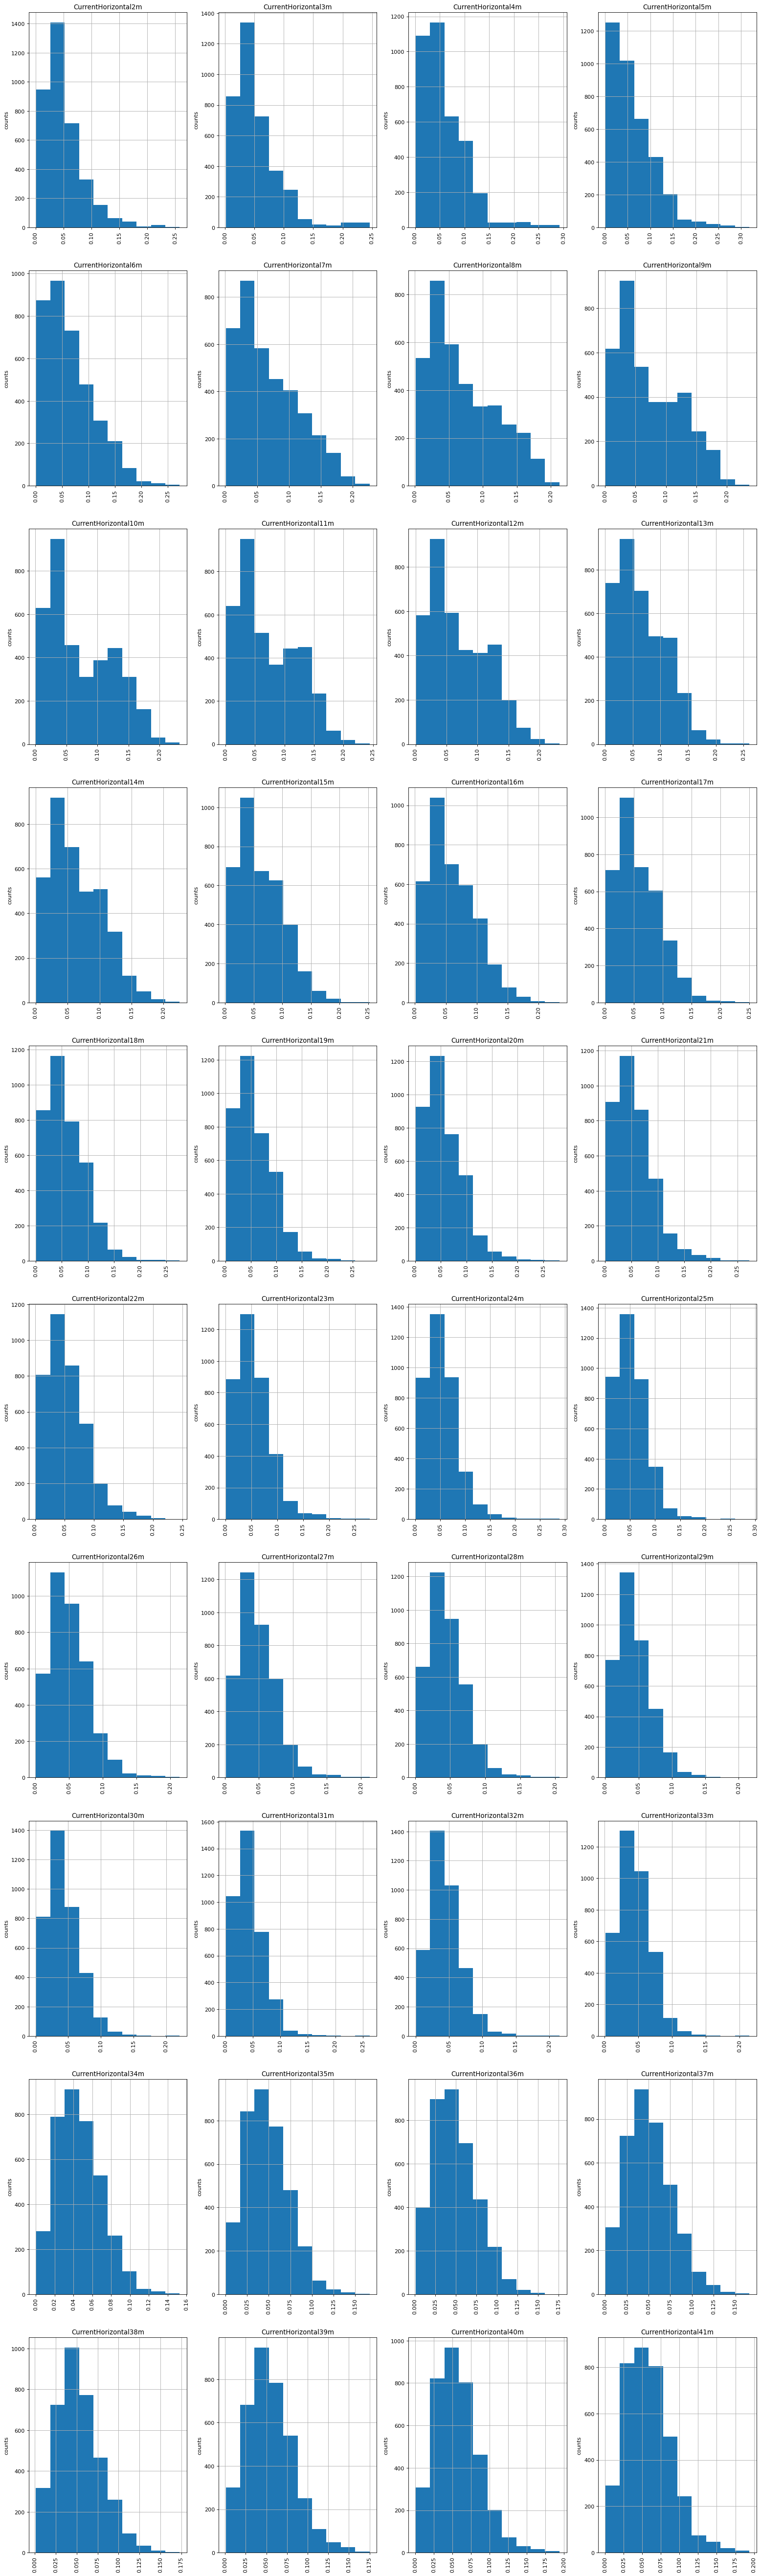

In [11]:
plotPerColumnDistribution(cutFrame.loc[:,'CurrentHorizontal2m':'CurrentHorizontal41m'], 40, 4)

## Center oxygen measurements

### Temperature

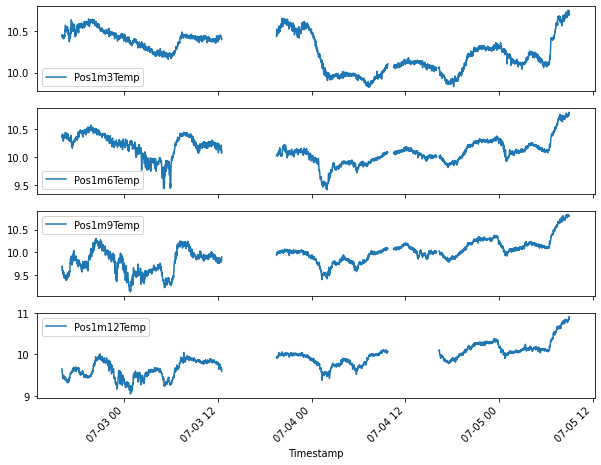

In [12]:
fig, ax = plt.subplots(4,1)
for key, i in enumerate(range(3,13,3)):
    df.loc[:,'Pos1m' + str(i) + 'Temp'].plot(ax=ax[key], rot = 45, legend=True, figsize=(10,8), sharex=True)

### Mean plot

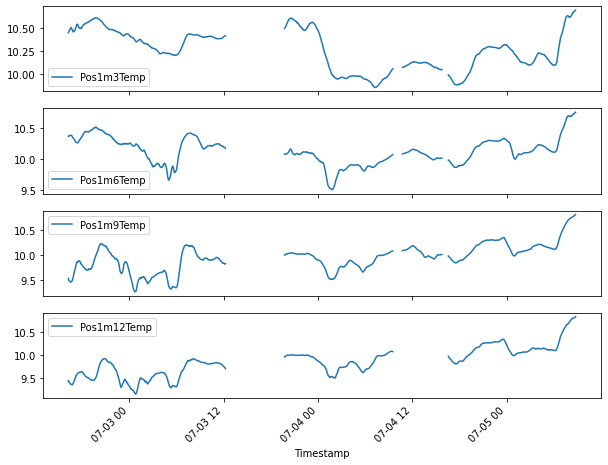

In [13]:
fig, ax = plt.subplots(4,1)
for key, i in enumerate(range(3,13,3)):
    df.loc[:,'Pos1m' + str(i) + 'Temp'].rolling(window = 30, center=True).mean().plot(ax=ax[key], rot = 45, legend=True, figsize=(10,8), sharex=True)
    # .resample('H').mean()

In [14]:
df_do = df[[col for col in df.columns if 'DO' in col]]
direction = np.array(['C', 'C','C','C','E','N','W','S','W','W','W','W','W','W','N','N','N','N','S','S','N','W'])
inside = np.array(['o' if 'Outside' in col else 'i' for col in df_do.columns])
distanceFromCage = np.array([25, 25, 25, 25, 4, 4, 4, 4, 5, 5, 2, 2, 4, 4, 5, 5, 2, 2, 4, 4, 4, 4])
depth = np.array([int(re.search('m\d+', col).group()[1:]) for col in df_do.columns])
newName = np.array(['$'+direction[i]+inside[i]+'^{'+str(distanceFromCage[i])+'}_{'+str(depth[i])+'}$' for i,k in enumerate(df_do.columns)])
#df_do.columns = newName

In [15]:
df_do #= df_do.rolling(window = 30, center=True).mean()

,Pos1m3DO,Pos1m6DO,Pos1m9DO,Pos1m12DO,Pos4m3DO,Pos5m3DO,Pos6m3DO,Pos7m3DO,Pos21m4DO,Pos21m2DO,...,Pos23m4DO,Pos23m2DO,Pos31m4DO,Pos31m2DO,OutsidePos32m2DO,OutsidePos32m4DO,SouthOutsidem3DO,Southm3DO,Northm3DO,Outsidem3DO
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-07-02 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-02 15:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101.4250,80.37461,66.17786,NaN
2019-07-02 15:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,103.6134,75.06496,65.97083,NaN
2019-07-02 15:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,103.8499,81.00690,66.96149,NaN
2019-07-02 15:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,104.4416,79.32155,69.74327,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-05 09:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101.4617,89.96364,87.24078,98.510898
2019-07-05 09:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.780340
2019-07-05 09:38:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.736097


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

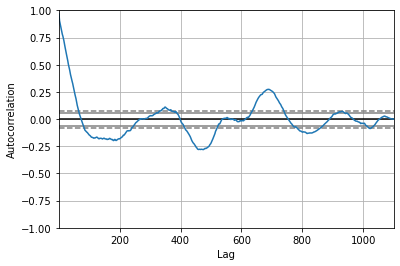

In [16]:
pd.plotting.autocorrelation_plot(df[['Pos1m3DO']].dropna().values[200:1300])

In [17]:
df[['Pos1m3DO']].dropna().values[1200:1400]

array([[63.374741],
       [64.608838],
       [66.048764],
       [67.832146],
       [71.754282],
       [74.878248],
       [74.484453],
       [68.741098],
       [68.189816],
       [68.594258],
       [68.925242],
       [71.113976],
       [69.977656],
       [68.433319],
       [68.893239],
       [70.253563],
       [70.27292 ],
       [69.369909],
       [68.549687],
       [66.986996],
       [66.875778],
       [66.249182],
       [65.004939],
       [64.949214],
       [63.991842],
       [62.587099],
       [61.303658],
       [61.510326],
       [63.213631],
       [64.024712],
       [63.447243],
       [63.693171],
       [62.053567],
       [60.089534],
       [61.888216],
       [62.261016],
       [61.491969],
       [61.43923 ],
       [60.186021],
       [59.852834],
       [60.718408],
       [61.470079],
       [60.985992],
       [60.97317 ],
       [60.598131],
       [61.297475],
       [61.043646],
       [60.650513],
       [60.11435 ],
       [62.773654],


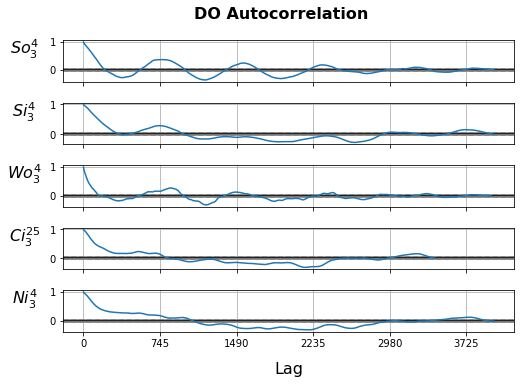

In [18]:
cols = np.array(['SouthOutsidem3DO', 'Southm3DO', 'Outsidem3DO', 'Pos1m3DO', 'Northm3DO'])
fig, ax = plt.subplots(cols.size,1, figsize=(7,5), sharex=True)
fig.suptitle('DO Autocorrelation', fontweight='bold', fontsize=16)
fig.tight_layout()
for i,col in enumerate(cols):
    pd.plotting.autocorrelation_plot(df_do.loc[:,col].dropna(), ax = ax[i])
    colName = newName[df_do.columns.tolist().index(col)]
    ax[i].set_xticks(np.arange(0, df_do.loc[:,col].dropna().size, 745))
    ax[i].set_ylabel(colName, fontweight="bold", rotation = 0, labelpad =25, fontsize = 16)
    ax[i].xaxis.label.set_visible(False)
ax0 = fig.add_subplot(111, frame_on=False)   # creating a single axes
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlabel('Lag', labelpad=30, fontsize = 16)
fig.savefig("DOautocorrelation", bbox_inches = 'tight')

Text(0.5, 0, 'Lag')

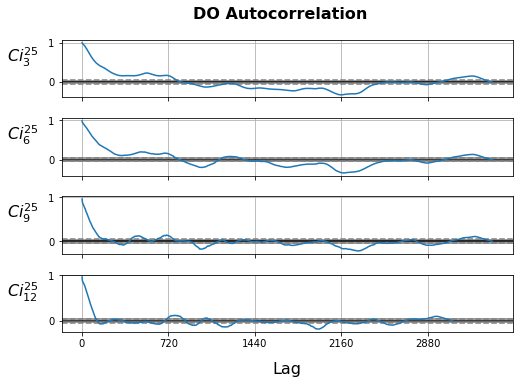

In [19]:
cols = np.array(['Pos1m3DO', 'Pos1m6DO', 'Pos1m9DO', 'Pos1m12DO'])
fig, ax = plt.subplots(cols.size,1, figsize=(7,5), sharex=True)
fig.suptitle('DO Autocorrelation', fontweight='bold', fontsize=16)
fig.tight_layout()
for i,col in enumerate(cols):
    pd.plotting.autocorrelation_plot(df_do.loc[:,col].dropna(), ax = ax[i])
    colName = newName[df_do.columns.tolist().index(col)]
    ax[i].set_xticks(np.arange(0, df_do.loc[:,col].dropna().size, 720))
    ax[i].set_ylabel(colName, fontweight="bold", rotation = 0, labelpad =25, fontsize = 16)
    ax[i].xaxis.label.set_visible(False)
ax0 = fig.add_subplot(111, frame_on=False)   # creating a single axes
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlabel('Lag', labelpad=30, fontsize = 16)
#ax0.set_ylabel('Depth', labelpad=30, fontsize = 16)
#fig.savefig("DOautocorrelationCenter", bbox_inches = 'tight')

In [20]:
df_do.columns

Index(['Pos1m3DO', 'Pos1m6DO', 'Pos1m9DO', 'Pos1m12DO', 'Pos4m3DO', 'Pos5m3DO',
       'Pos6m3DO', 'Pos7m3DO', 'Pos21m4DO', 'Pos21m2DO', 'OutsidePos22m2DO',
       'OutsidePos22m4DO', 'Pos23m4DO', 'Pos23m2DO', 'Pos31m4DO', 'Pos31m2DO',
       'OutsidePos32m2DO', 'OutsidePos32m4DO', 'SouthOutsidem3DO', 'Southm3DO',
       'Northm3DO', 'Outsidem3DO'],
      dtype='object')

<AxesSubplot:>

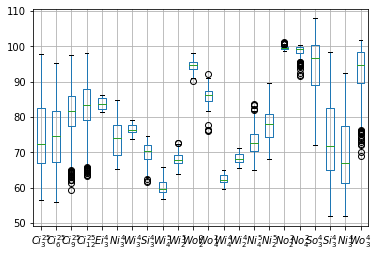

In [21]:
df_do.columns = newName
df_do.boxplot()

In [22]:
#fig, ax = plt.subplots(figsize=(15,7))
#sns.set_theme(style = "whitegrid")
#sns.boxplot(data = df_do, ax = ax)
#scaler = StandardScaler()
#scaler = scaler.fit(df_do)
#reg = LinearRegression().fit()
#df_do_st = scaler.transform(df_do)
#depths = np.array([[int(re.search('m\d+', col).group()[1:]) for i in np.arange(0, df_do_st.shape[0])] for col in df_do.columns])
#plt.xticks([i for i,k in enumerate(newName)], newName)
#plt.show()

In [23]:
df_sorted.boxplot(figsize = (12,10), color = 'black')
label_names = ['']

NameError: name 'df_sorted' is not defined

In [ ]:
df_sorted.columns
df_sorted.columns = ['$W_i', 'Pos23m2DO', 'Pos31m2DO', 'Pos1m3DO', 'Pos4m3DO',
       'Pos5m3DO', 'Pos6m3DO', 'Pos7m3DO', 'Southm3DO', 'Northm3DO',
       'Pos21m4DO', 'Pos23m4DO', 'Pos31m4DO', 'Pos1m6DO', 'Pos1m9DO',
       'Pos1m12DO']

In [ ]:
depths = np.array([2,3,4,6,9,12])
do_3m = np.array([np.nanmean([df[col] for col in df.columns if 'm'+str(i) in col and 'DO' in col],axis=0) for i in depths])
do_3m = pd.DataFrame(data = do_3m.T, index = df.index.strftime('%d-%m'), columns = depths)
#do_3m.index = do_3m.index.strftime('%d-%m')
plt.figure(figsize = (4,8))
ax = sns.heatmap(do_3m, cmap = 'viridis')
#do_3m.boxplot(figsize = (14,10), grid = False)

In [ ]:
df_center = df[[col for col in df.columns if 'Pos1' in col and 'DO' in col]]
df_center.index = df_center.index.strftime('%d-%m')

plt.figure(figsize = (4,8))
ax = sns.heatmap(df_center, cmap = 'jet')


#ax.set_yticklabels(df_center.index.strftime('%d-%m-%Y'))

### Remove trend with differencing

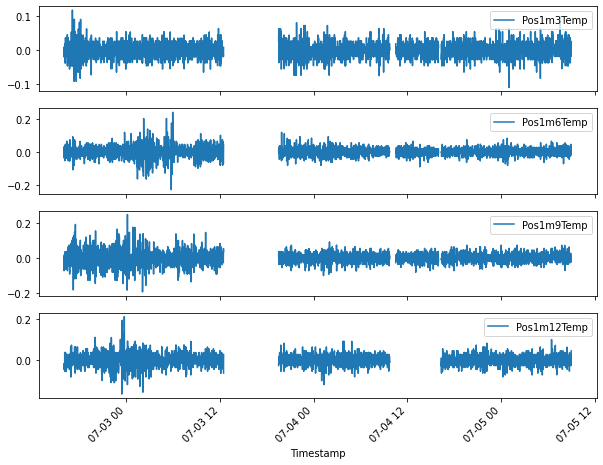

In [24]:
fig, ax = plt.subplots(4,1)
for key, i in enumerate(range(3,13,3)):
    df.loc[:,'Pos1m' + str(i) + 'Temp'].diff().plot(ax=ax[key], rot = 45, legend=True, figsize=(10,8), sharex=True)

## Temperature measurements

In [ ]:
tempColumns = [col for col in df.columns if 'Temp' in col]
positions = []
depths = [1, 2, 3, 4, 6, 9, 12]

fig, axes = plt.subplots(15,len(depths), figsize=(20,18))
fig.tight_layout()

for key, col in enumerate(tempColumns):
    depth = int(re.search('m\d+', col).group()[1:])  # Get sensor depth
    pos = col[0:re.search('m\d+', col).start()]      # Get sensor position

    if pos not in positions:   # Slow, switch to dict later maybe
        positions.append(pos)

    df.loc[:,col].plot(ax=axes[positions.index(pos), depths.index(depth)], ylim=(8,12))


for key, ax in enumerate(axes[0]):
    ax.set_title(str(depths[key]) + 'm')
    #plt.xticks(rotation=45)
    
for key, ax in enumerate(axes[:,0]):
    ax.set_ylabel(positions[key])
    ax.xaxis.label.set_visible(False)


# TODO: Remove Pos 22 temp measurements?

In [ ]:
df.loc[:,tempColumns].plot(subplots=True, figsize=(12,15), ylim=(8,12))
plt.savefig("temporalPos")

In [ ]:
ax = df.loc[:,tempColumns].diff().plot(subplots=True, figsize=(12,30), linewidth=0.5, sharex=False)
plt.tight_layout()
for axis in ax:
    axis.xaxis.label.set_visible(False)

## Note on Temperature measurement intervals

Moving of sensors cause the temperature to be too high at the start of measurements. This is a problem for positions that were only measured at for a very short time. See position 22 for example.

# DO measurements

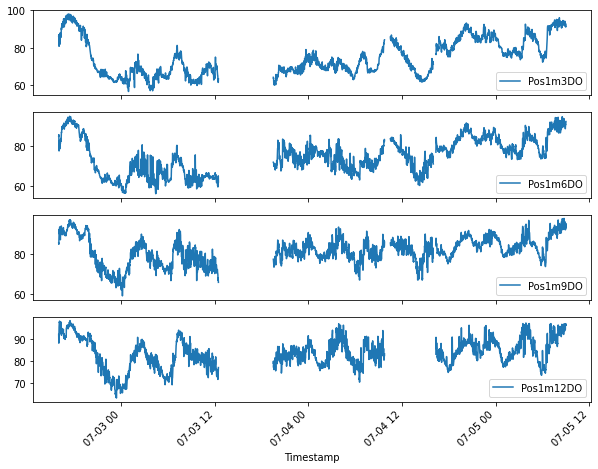

In [25]:
fig, ax = plt.subplots(4,1)
for key, i in enumerate(range(3,13,3)):
    #df.loc[:,col].plot(ax=axes[positions.index(pos), depths.index(depth)], ylim=(50, 110))
    df.loc[:,'Pos1m' + str(i) + 'DO'].plot(ax=ax[key], rot = 45, legend=True, figsize=(10,8), sharex=True, sharey=True)

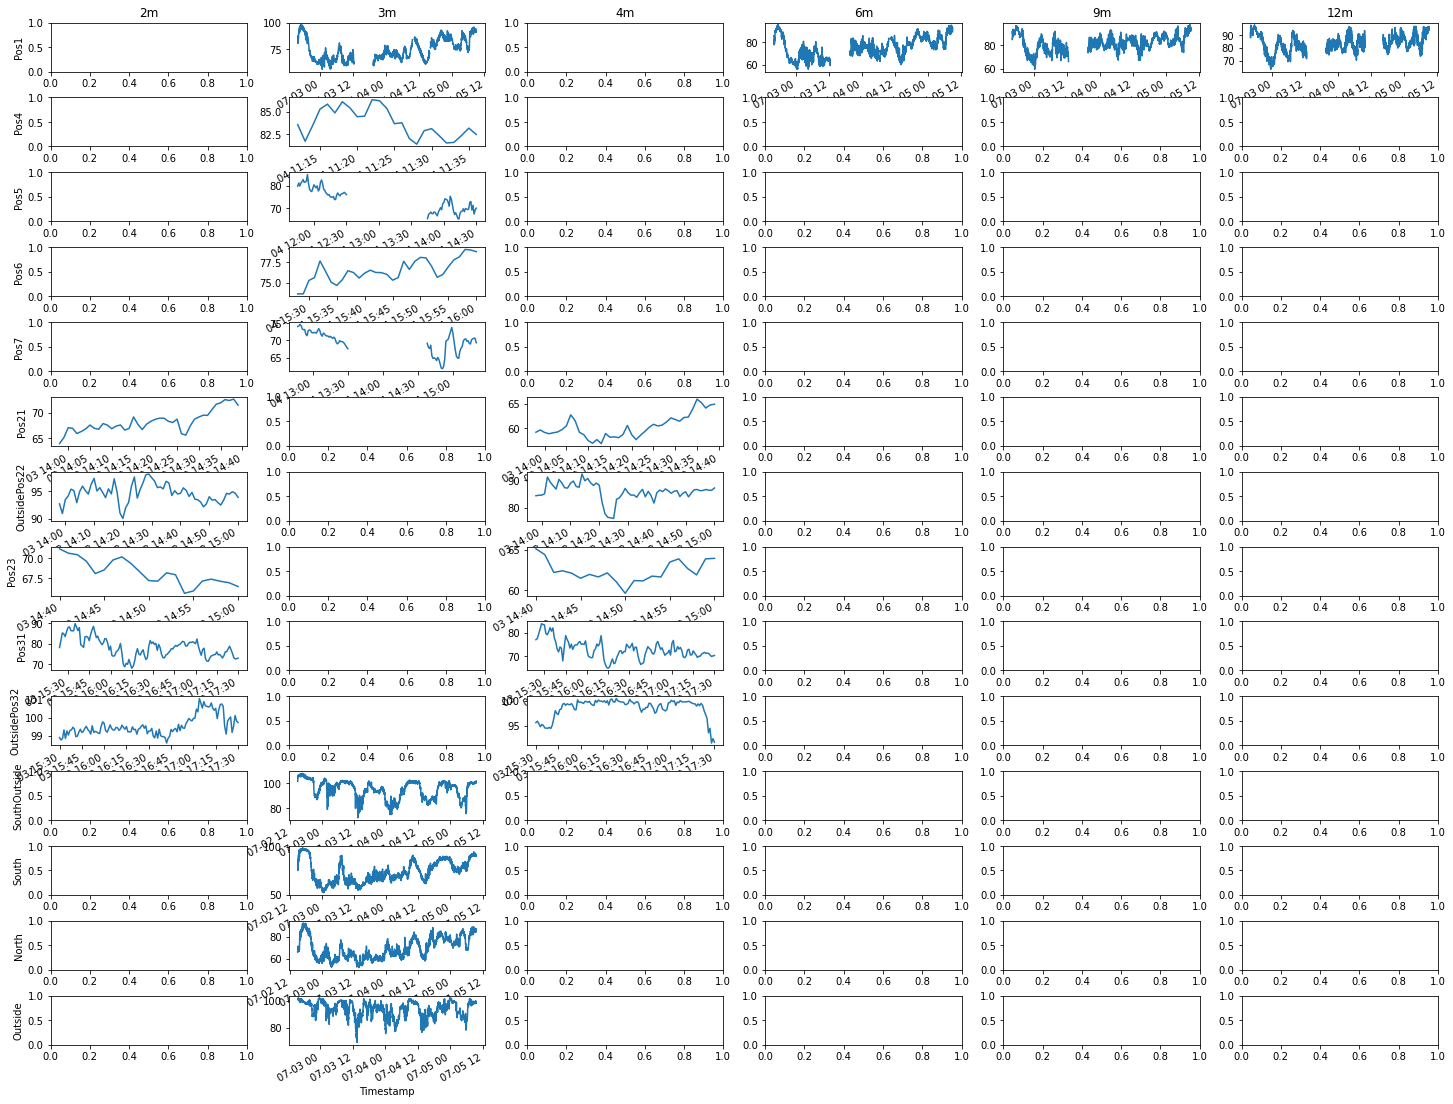

In [26]:
DOcolumns = [col for col in df.columns if 'DO' in col]
positions = []
depths = [2, 3, 4, 6, 9, 12]

fig, axes = plt.subplots(14,len(depths), figsize=(20,18))
fig.tight_layout()

for key, col in enumerate(DOcolumns):
    depth = int(re.search('m\d+', col).group()[1:])  # Get sensor depth
    pos = col[0:re.search('m\d+', col).start()]      # Get sensor position

    if pos not in positions:   # Slow, switch to dict later maybe
        positions.append(pos)

    df.loc[:,col].plot(ax=axes[positions.index(pos), depths.index(depth)])


for key, ax in enumerate(axes[0]):
    ax.set_title(str(depths[key]) + 'm')
    #plt.xticks(rotation=45)
    
for key, ax in enumerate(axes[:,0]):
    ax.set_ylabel(positions[key])
    ax.xaxis.label.set_visible(False)

In [ ]:
df.loc[:,DOcolumns].plot(subplots=True, figsize=(12,30))

In [ ]:
ax = df.loc[:,DOcolumns].diff().plot(subplots=True, figsize=(12,30), linewidth=0.5, sharex=False)
#plt.tight_layout()
#plt.xaxis.label.set_visible(False)
plt.suptitle('DO differences')
plt.tight_layout()
plt.subplots_adjust(top=0.97)
for axis in ax:
    axis.xaxis.label.set_visible(False)

In [ ]:
x = mdates.date2num(df.index[df['Southm3DO'].isna() == 0])
coeff = np.polyfit(x,df['Southm3DO'].dropna(), 16)
poly = np.poly1d(coeff)
new_x = np.linspace(x[0], x[-1])
new_y = poly(new_x)

plt.plot(df.index[df['Southm3DO'].isna() == 0], df['Southm3DO'].dropna(), new_x, new_y)

## Scatter Matrix (Position 1)

In [ ]:
#ax = pd.plotting.scatter_matrix(df.loc[:,tempColumns[:4] + DOcolumns[:4]], figsize=(14,14), alpha= 0.20, diagonal='kde', color = 'tab:blue', edgecolors = 'black')
ax = sns.pairplot(df.loc[:,tempColumns[:4] + DOcolumns[:4]], diag_kind= 'kde', corner=True)

#for i in range(np.shape(ax)[0]):
    #for j in range(np.shape(ax)[1]):
        #if i < j:
            #ax[i,j].set_visible(False)

In [ ]:
pd.plotting.autocorrelation_plot(df["TideLevel"].dropna().resample("H").mean())

## DO autocorrelation

In [ ]:
#pd.plotting.autocorrelation_plot(df.loc[:,DOcolumns].dropna())

fig, axes = plt.subplots(14,len(depths), figsize=(20,18))
fig.tight_layout()

for key, col in enumerate(DOcolumns):
    depth = int(re.search('m\d+', col).group()[1:])  # Get sensor depth
    pos = col[0:re.search('m\d+', col).start()]      # Get sensor position

    if pos not in positions:   # Slow, switch to dict later maybe
        positions.append(pos)
    
    ax = pd.plotting.autocorrelation_plot(df.loc[:,col].dropna(), ax=axes[positions.index(pos), depths.index(depth)])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(np.arange(0, df.loc[:,col].dropna().size, 745))
    #df.loc[:,col].plot(ax=axes[positions.index(pos), depths.index(depth)], ylim=(50, 110))


for key, ax in enumerate(axes[0]):
    ax.set_title(str(depths[key]) + 'm', fontweight="bold")
    ax.xaxis.label.set_visible(False)
    #plt.xticks(rotation=45)
    
for key, ax in enumerate(axes[:,0]):
    ax.set_ylabel(positions[key], fontweight="bold")
    ax.xaxis.label.set_visible(False)

## Temperature autocorrelation

In [ ]:
depths = [1, 2, 3, 4, 6, 9, 12]
fig, axes = plt.subplots(15,len(depths), figsize=(20,18))
fig.tight_layout()

for key, col in enumerate(tempColumns):
    depth = int(re.search('m\d+', col).group()[1:])  # Get sensor depth
    pos = col[0:re.search('m\d+', col).start()]      # Get sensor position

    if pos not in positions:   # Slow, switch to dict later maybe
        positions.append(pos)
    
    ax = pd.plotting.autocorrelation_plot(df.loc[:,col].dropna(), ax=axes[positions.index(pos), depths.index(depth)])
    ax.set_ylabel('')
    ax.set_xlabel('')
    #df.loc[:,col].plot(ax=axes[positions.index(pos), depths.index(depth)], ylim=(50, 110))


for key, ax in enumerate(axes[0]):
    ax.set_title(str(depths[key]) + 'm', fontweight="bold")
    ax.xaxis.label.set_visible(False)
    #plt.xticks(rotation=45)
    
for key, ax in enumerate(axes[:,0]):
    ax.set_ylabel(positions[key], fontweight="bold")
    ax.xaxis.label.set_visible(False)

In [ ]:
fig, ax = plt.subplots(22,1,figsize=(12,30))
for i, col in enumerate(DOcolumns):
    pd.plotting.autocorrelation_plot(df.loc[:,col].dropna(), ax=ax[i])
    ax[i].set_title(col)

plt.suptitle('DO Autocorrelations')
plt.tight_layout()
plt.subplots_adjust(top=0.96)
for axis in ax:
    axis.xaxis.label.set_visible(False)


In [ ]:
pd.plotting.autocorrelation_plot(df['Pos1m3DO'].dropna())

In [ ]:
df.loc[:,DOcolumns[-5]].hist()

In [ ]:
fig = plt.figure(figsize=(8,6))
mu = 0
variance = 2
sigma = np.sqrt(variance)
x = np.linspace(-4, 4, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), lw=3)
for i in np.arange(mu-2*sigma, mu+3*sigma, sigma):
    plt.vlines(mu+i, ymin=0.0, ymax = stats.norm.pdf(i, mu, sigma), color='black', ls='--', lw=2)
plt.xticks([mu+i for i in np.arange(mu-2*sigma, mu+3*sigma, sigma)], ['$\mu - 2\sigma$', '$\mu - \sigma$', '$\mu$', '$\mu + \sigma$', '$\mu - 2\sigma$'], size=15)
plt.ylim(0.0, 0.3)
plt.xlim(-4.0, 4.0)
plt.yticks([])
plt.ylabel('f(x)', size= 15)

# Hide the right and top spines
ax = fig.axes[0]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('gaussianDistribution')